In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Arial')
from math import nan

from qtrendutils import mapplot_utils as mymaps
from qtrendutils import grid_utils as grid
from qtrendutils import colormap_utils as mycolors

import warnings
warnings.filterwarnings('ignore')

In [2]:
plotpath="/project/cas/islas/python_plots/qtrend_paper/figures/supplemental/"

### Calculate the aridity index

In [3]:
pet_tc = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/Aridity_Index/PET_Terraclim_1980_2020_native.nc")
ppt_tc = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/Aridity_Index/PPT_Terraclim_1980_2020_native.nc")
aridity = ppt_tc.ppt / pet_tc.pet
aridity = aridity.load()
aridity = grid.fliplon_neg2pos(aridity,'lon')

In [4]:
isd = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/vaporpressures_ISD_fromhourly_ge4pd.nc")
#stations aridity
ariditystat = xr.DataArray(np.zeros([isd.station.size]), coords=[isd.station], dims=['station'], name='aridity')
for istation in np.arange(0,isd.station.size,1):
    lonval = isd.lons.isel(station=istation).values
    latval = isd.lats.isel(station=istation).values
    
    lonargmin = np.argmin(np.abs(aridity.lon.values - lonval))
    aridityuse = aridity.isel(lon=lonargmin)
    latargmin = np.argmin(np.abs(aridity.lat.values - latval))
    aridityuse = aridityuse.isel(lat=latargmin)
    ariditystat[istation] = aridityuse.values

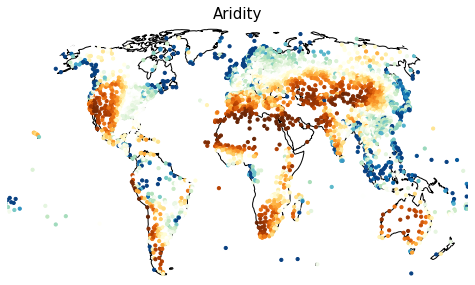

In [4]:
fig = plt.figure(figsize=(16,16))

ax = mymaps.contourmap_continentsonly_robinson_noborder_scatter_pos(fig, ariditystat, isd.lons, isd.lats,0.1,0,2,'Aridity',
                                                                    0.05,0.45,0.75,0.97,cmap='precip')

In [5]:
isd = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/vaporpressures_ISD_fromhourly_ge4pd.nc")
isd = xr.merge([isd, ariditystat])
isd_arid = isd.where( (isd.aridity > 0.05) & (isd.aridity < 0.5), drop=True)

### Find the number of stations that surface with given thresholds of the number of times per day and the number of bad months

In [6]:
badmonths = xr.where(isd_arid.nbaddays > 15,1,0).sum('time')
nperday=[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
nstats = np.zeros([len(nperday),500])
for iperday in np.arange(0,len(nperday),1):
    isd_npd = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/vaporpressures_ISD_fromhourly_ge"+str(nperday[iperday])+"pd.nc")
    isd_npd = xr.merge([isd_npd, ariditystat])
    isd_npd_arid = isd_npd.where( (isd_npd.aridity > 0.05) & (isd.aridity < 0.5), drop=True)
    badmonths = xr.where(isd_npd_arid.nbaddays > 15, 1, 0).sum('time')
    for i in np.arange(0,500,1):
        nstats[iperday, i] = ((xr.where(badmonths <= i,1,0).sum('station'))/isd_npd_arid.station.size)*100.     

### Find the best stations with 18 measurements per day and 0 bad months

In [7]:
isd_18 = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/vaporpressures_ISD_fromhourly_ge18pd.nc")
badmonths = xr.where(isd_18.nbaddays > 15, 1, 0).sum('time')
isd_18 = isd_18.where(badmonths ==0 , drop=True)

### Set up the color bar for the line plot

In [8]:
from matplotlib.colors import ListedColormap ## used to create custom colormaps
import matplotlib.colors as mcolors

def makecolormap(n):
    if (int(n/2) == n/2):
        # even number of contours
        nneg=n/2
        npos=n/2
    else:
        nneg = (n+1)/2
        npos = (n+1)/2       
    
    nwhite=0
    colors1 = plt.cm.Blues_r(np.linspace(0,1, int(nneg)))
    colors2 = plt.cm.YlOrRd(np.linspace(0,1, int(npos)))
    colorsw = np.ones((nwhite,4))
    colors = np.vstack((colors1, colorsw, colors2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

#    nblues=6
#    nreds=n-nblues
#    colors1 = plt.cm.Blues_r(np.linspace(0,1, int(nblues)))
#    colors2 = plt.cm.YlOrRd(np.linspace(0,0.6, int(nreds)))
#    colors = np.vstack((colors1, colors2))
#    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap',colors)
    return mymap, colors

In [9]:
def plotstationmap(fig, nperday, x1, x2, y1, y2, titlestr):
    isd = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/vaporpressures_ISD_fromhourly_ge"+str(nperday)+"pd.nc")
    badmonths = xr.where(isd.nbaddays > 15, 1, 0).sum('time')
    isd_0bad = isd.where(badmonths == 0 , drop=True)
    isd_12bad = isd.where( (badmonths > 0) & (badmonths <=12), drop=True)
    isd_24bad = isd.where( (badmonths > 12) & (badmonths <= 24), drop=True)
    isd_36bad = isd.where( (badmonths > 24) & (badmonths <= 36), drop=True)
    isd_48bad = isd.where( (badmonths > 36) & (badmonths <= 48), drop=True)

    ax = mymaps.contourmap_continentsonly_robinson_noborder_scatter_pos(fig, isd_48bad.lons*0,
                                                         np.array(isd_48bad.lons), np.array(isd_48bad.lats),0.2,-2,2,titlestr,
                                                         x1,x2,y1,y2, onecolor=True, color='mediumpurple', fontsize=18)
    ax = mymaps.contourmap_continentsonly_robinson_noborder_scatter_pos(fig, isd_36bad.lons*0,
                                                         np.array(isd_36bad.lons), np.array(isd_36bad.lats),0.2,-2,2,' ',
                                                                  0.5,0.9,0.75,0.97, onecolor=True, color='orchid', oplot=True, ax=ax, markersize=8)
    ax = mymaps.contourmap_continentsonly_robinson_noborder_scatter_pos(fig, isd_24bad.lons*0,
                                                         np.array(isd_24bad.lons), np.array(isd_24bad.lats),0.2,-2,2,' ',
                                                                  0.5,0.9,0.75,0.97, onecolor=True, color='lightsteelblue', oplot=True, ax=ax, markersize=8)
    ax = mymaps.contourmap_continentsonly_robinson_noborder_scatter_pos(fig, isd_12bad.lons*0,
                                                         np.array(isd_12bad.lons), np.array(isd_12bad.lats),0.2,-2,2,' ',
                                                                  0.5,0.9,0.75,0.97, onecolor=True, color='gray', oplot=True, ax=ax, markersize=8)
    ax = mymaps.contourmap_continentsonly_robinson_noborder_scatter_pos(fig, isd_0bad.lons*0,
                                                         np.array(isd_0bad.lons), np.array(isd_0bad.lats),0.2,-2,2,' ',
                                                                  0.5,0.9,0.75,0.97, onecolor=True, color='black', oplot=True, ax=ax, markersize=8)

    from matplotlib.lines import Line2D
    legendparts = [ Line2D([0],[0], color='w', markeredgecolor='black', markerfacecolor='black', marker='o', markersize=4),
                Line2D([0],[0], color='w', markeredgecolor='gray', markerfacecolor='gray', marker='o', markersize=4),
                Line2D([0],[0], color='w', markeredgecolor='lightsteelblue', markerfacecolor='lightsteelblue', marker='o', markersize=4),
                Line2D([0],[0], color='w', markeredgecolor='orchid', markerfacecolor='orchid', marker='o', markersize=4),
                Line2D([0],[0], color='w', markeredgecolor='mediumpurple', markerfacecolor='mediumpurple', marker='o', markersize=4)]
    legendlabels=['0','0 $<$ # $\leq$ 12','12 $<$ # $\leq$ 24','24 $<$ # $\leq$ 36', '36 $<$ # $\leq$ 48']
    ax.legend(legendparts, legendlabels, bbox_to_anchor = (0.28,0.26), ncol=1, frameon = True, facecolor='white', edgecolor=None,
          framealpha=None, shadow=True)

    return ax

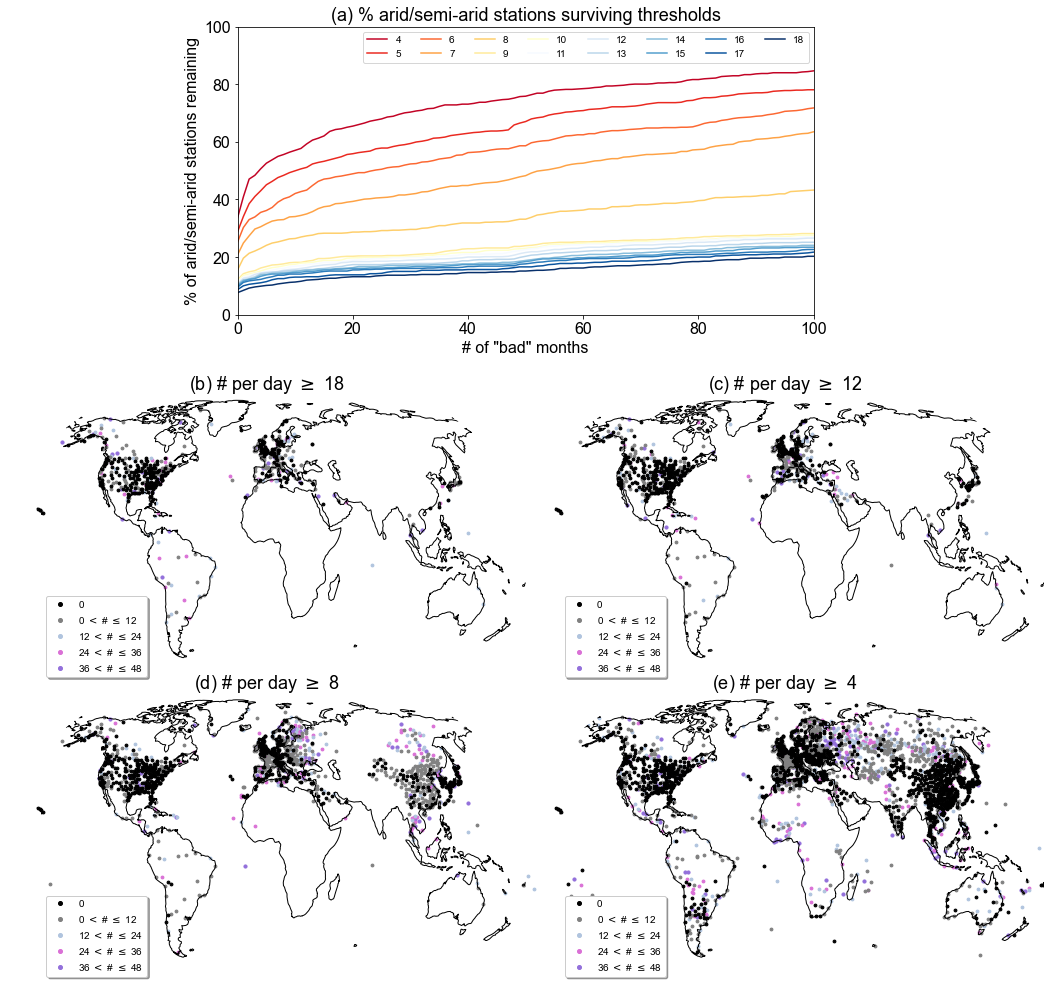

In [10]:
fig = plt.figure(figsize=(16,16))

#---------Number of stations surviving different thresholds line plot
mymap, colors = makecolormap(len(nperday))

ax = fig.add_axes([0.25,0.7,0.5,0.25])
ax.set_title('(a) % arid/semi-arid stations surviving thresholds', fontsize=18)
ax.set_ylim(0,100)
ax.set_xlim(0,100)
ax.set_xticks([0,20,40,60,80,100])
ax.set_xticklabels(['0','20','40','60','80','100'], fontsize=16)
ax.set_yticks([0,20,40,60,80,100])
ax.set_yticklabels(['0','20','40','60','80','100'], fontsize=16)
ax.set_ylabel('% of arid/semi-arid stations remaining', fontsize=16)
ax.set_xlabel('# of "bad" months', fontsize=16)
for i in np.arange(0,len(nperday),1):
    ax.plot(np.arange(0,500,1), nstats[i,:], color=colors[len(nperday)-i-1], label=nperday[i])
    
ax.legend(ncol=8)
#-------------------------------------------------------------------


#------
ax = plotstationmap(fig, 18, 0.05,0.5,0.4,0.63,'(b) # per day $\geq$ 18')
ax = plotstationmap(fig, 12, 0.5,0.95,0.4,0.63,'(c) # per day $\geq$ 12')
ax = plotstationmap(fig, 8, 0.05,0.5,0.14,0.37,'(d) # per day $\geq$ 8')
ax = plotstationmap(fig, 4, 0.5,0.95,0.14,0.37,'(e) # per day $\geq$ 4')

fig.savefig(plotpath+'figS1.pdf', bbox_inches='tight', facecolor='white')